In [37]:
#Finding stay points from a user trajectory data.
#Stay points are goverened by two parameters, time threshold and distance threshold.
#If user has spend more than threshold time(10 mins) at the same geographical location(threshold distance 50m),
# then this location is users stay point.
#This can be users home, work, a bus station or a restaurant. 

#load all the files for a user
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 

pd.options.mode.chained_assignment = None

#source, destination path and filter till date(till when the data needs to be considered). Change according to your needs
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/017/Trajectory/200*.plt" 
dest_file_staypoints = "/home/shashank/Documents/location/Data/StayPointsUser_17_2008.csv" 
fltr_till_date = "2008-12-31 00:00:00"


#Load file names for user. Change here for different user replace 000 or even path as required
filenames = glob.glob(file_source_raw)

#Read the files
list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

#put the data from list into one dataframe
combined_df = pd.concat(list_of_dfs, ignore_index=True)

#rename columns
combined_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
combined_df['ClusterId'] = -1
combined_df['ClusterMeanLat'] = -1
combined_df['ClusterMeanLon'] = -1
combined_df['StayPoint'] = -1
combined_df['SignificantPlace'] = -1

#add timestamp index
combined_df["Timestamp"] = combined_df["Date"].map(str) + " " + combined_df["Time"]
combined_df.Timestamp = pd.to_datetime(combined_df.Timestamp)
combined_df.index = pd.to_datetime(combined_df.Timestamp)

#combined_df.size
combined_df.head()

,Latitude,Longitude,0,Altitude,NumDays,Date,Time,ClusterId,ClusterMeanLat,ClusterMeanLon,StayPoint,SignificantPlace,Timestamp
Timestamp,,,,,,,,,,,,,
2009-02-25 12:48:45,39.985062,116.320027,0,229.7,39869.533854,2009-02-25,12:48:45,-1,-1,-1,-1,-1,2009-02-25 12:48:45
2009-02-25 12:48:46,39.985072,116.319998,0,229.7,39869.533866,2009-02-25,12:48:46,-1,-1,-1,-1,-1,2009-02-25 12:48:46
2009-02-25 12:48:48,39.984990,116.319933,0,206.7,39869.533889,2009-02-25,12:48:48,-1,-1,-1,-1,-1,2009-02-25 12:48:48
2009-02-25 12:48:51,39.984922,116.319825,0,180.4,39869.533924,2009-02-25,12:48:51,-1,-1,-1,-1,-1,2009-02-25 12:48:51
2009-02-25 12:48:54,39.984920,116.319732,0,180.4,39869.533958,2009-02-25,12:48:54,-1,-1,-1,-1,-1,2009-02-25 12:48:54


In [38]:
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

In [39]:
#This function is to cluster the points together if thier distance is less than 50 meters.
#If the cluster has a total duration of 10 minutes or greater, then add it to a stay point

def cluster(newlat, newlon, row, count):
    
    currcluster = sampled_df['ClusterId'][row-1]
    sampled_df['ClusterId'][row] = -1
    sampled_df['ClusterMeanLat'][row] = -1
    sampled_df['ClusterMeanLon'][row] = -1
    sampled_df['StayPoint'][row] = -1
    sampled_df['SignificantPlace'][row] = -1
    clulat = sampled_df['ClusterMeanLat'][row-1]
    clulon = sampled_df['ClusterMeanLon'][row-1]
    
    #import pdb; pdb.set_trace()
    if meters(clulat, clulon, newlat, newlon)<= 50:
        sampled_df['ClusterId'][row] = currcluster
        sampled_df['ClusterMeanLat'] = sampled_df.groupby('ClusterId')['Latitude'].transform(np.mean)
        sampled_df['ClusterMeanLon'] = sampled_df.groupby('ClusterId')['Longitude'].transform(np.mean)
        count = count + 1
    else:
        
        if count >= 2:
            #import pdb; pdb.set_trace()
            MinClusTime = sampled_df['Timestamp'][row-count]
            MaxClusTime = sampled_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            #import pdb; pdb.set_trace()
            if (l >= 10):
                sampled_df.loc[ (sampled_df['ClusterId']==currcluster), 'StayPoint'] = 1
        count = 1
        sampled_df['ClusterMeanLat'][row] = sampled_df['Latitude'][row]
        sampled_df['ClusterMeanLon'][row] = sampled_df['Longitude'][row]
        sampled_df['ClusterId'][row] = currcluster + 1
    return count

In [40]:
#Resample the data with every two minutes. Remove this if you like to process the entire file.
#Note, it could take some time to run the further sections of the file size is very large.
sampled_df = combined_df.resample('2T').mean()
sampled_df["Timestamp"] = sampled_df.index
sampled_df = sampled_df.dropna()

#Select the data you want to proceed with
sampled_df = sampled_df[sampled_df["Timestamp"] <= fltr_till_date]

#len(sampled_df)
#sampled_df.tail()

In [41]:
#Read the file in an online manner as the points come and assign the points to clusters

row =1
count = 1
sampled_df['ClusterId'][row-1] = 0
sampled_df['ClusterMeanLat'][row-1] = sampled_df['Latitude'][0]
sampled_df['ClusterMeanLon'][row-1] = sampled_df['Longitude'][0]
sampled_df['StayPoint'][row-1] = -1
sampled_df['SignificantPlace'][row-1] = -1
while row < len(sampled_df):
    #import pdb; pdb.set_trace()
    count = cluster(sampled_df['Latitude'][row], sampled_df['Longitude'][row], row, count)
    row= row + 1

In [42]:
#Save the file to a location for further analysis. Change the file name accordingly
sampled_df.to_csv(dest_file_staypoints, sep='\t', encoding='utf-8')

In [43]:
#copy the significant places into another dataframe for visualization
staypts_df = sampled_df.loc[sampled_df['StayPoint'] == 1]

#count total stay points
staypts_df['ClusterId'].nunique()

133

In [44]:
staypts_df

,Latitude,Longitude,0,Altitude,NumDays,ClusterId,ClusterMeanLat,ClusterMeanLon,StayPoint,SignificantPlace,Timestamp
Timestamp,,,,,,,,,,,
2008-10-30 09:54:00,40.015220,116.338636,0.0,117.084615,39751.413036,14.0,40.015292,116.338404,1.0,-1.0,2008-10-30 09:54:00
2008-10-30 09:56:00,40.015405,116.338133,0.0,114.800000,39751.414217,14.0,40.015292,116.338404,1.0,-1.0,2008-10-30 09:56:00
2008-10-30 09:58:00,40.015582,116.338158,0.0,114.800000,39751.415926,14.0,40.015292,116.338404,1.0,-1.0,2008-10-30 09:58:00
2008-10-30 10:00:00,40.015323,116.338242,0.0,114.800000,39751.418015,14.0,40.015292,116.338404,1.0,-1.0,2008-10-30 10:00:00
2008-10-30 10:02:00,40.015034,116.338404,0.0,111.500000,39751.418385,14.0,40.015292,116.338404,1.0,-1.0,2008-10-30 10:02:00
2008-10-30 10:04:00,40.015186,116.338848,0.0,103.680000,39751.420375,14.0,40.015292,116.338404,1.0,-1.0,2008-10-30 10:04:00
2008-10-30 12:02:00,40.017908,116.345157,0.0,141.466667,39751.502216,31.0,40.017670,116.344973,1.0,-1.0,2008-10-30 12:02:00
2008-10-30 12:04:00,40.017798,116.344683,0.0,142.420000,39751.503755,31.0,40.017670,116.344973,1.0,-1.0,2008-10-30 12:04:00
2008-10-30 12:06:00,40.017625,116.345029,0.0,144.011111,39751.504585,31.0,40.017670,116.344973,1.0,-1.0,2008-10-30 12:06:00


In [33]:
#load the staypoints file
staypts_df = pd.read_csv(dest_file_staypoints, sep='\t')

#delete all non-staypoints
staypts_df = staypts_df.loc[staypts_df['StayPoint'] == 1]

#make index as datetime
staypts_df.index = pd.to_datetime(staypts_df.Timestamp)

#add a column hour for pivot table
staypts_df['Hour'] = staypts_df.index.hour

#sort based on hours
staypts_df = staypts_df.sort_values(['Hour'])

#count a cluster existence in each hour of te day
pivot_df_hour_count = staypts_df.pivot_table(values='Latitude', index='ClusterId',columns='Hour',aggfunc=len,  fill_value=0)

#copy hour count pivot to a new pivot where percentage weight of each staypount in the hour is calculated
pivot_df_hour_count.columns.name = None
pivot_df_per_weight = pivot_df_hour_count.copy()

for column in pivot_df_per_weight:
    pivot_df_per_weight[column] = round(pivot_df_per_weight[column] / pivot_df_per_weight[column].sum() * 100, 2)
    
pivot_df_per_weight

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,23
ClusterId,,,,,,,,,,,,,,,,,,,,,
14.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.61,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0
31.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0
125.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.90,0.00,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0
141.0,0.00,0.00,0.00,0.00,0.00,0.00,2.44,1.75,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0
145.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.72,0.00,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,12.5
237.0,15.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.87,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0
319.0,0.00,3.70,0.00,0.00,0.00,0.00,0.00,0.00,1.72,0.00,...,4.55,0.0,14.29,9.09,0.0,0.0,0.00,0.0,0.0,0.0
364.0,0.00,0.00,0.00,0.00,8.33,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0
380.0,0.00,0.00,0.00,0.00,0.00,4.94,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0


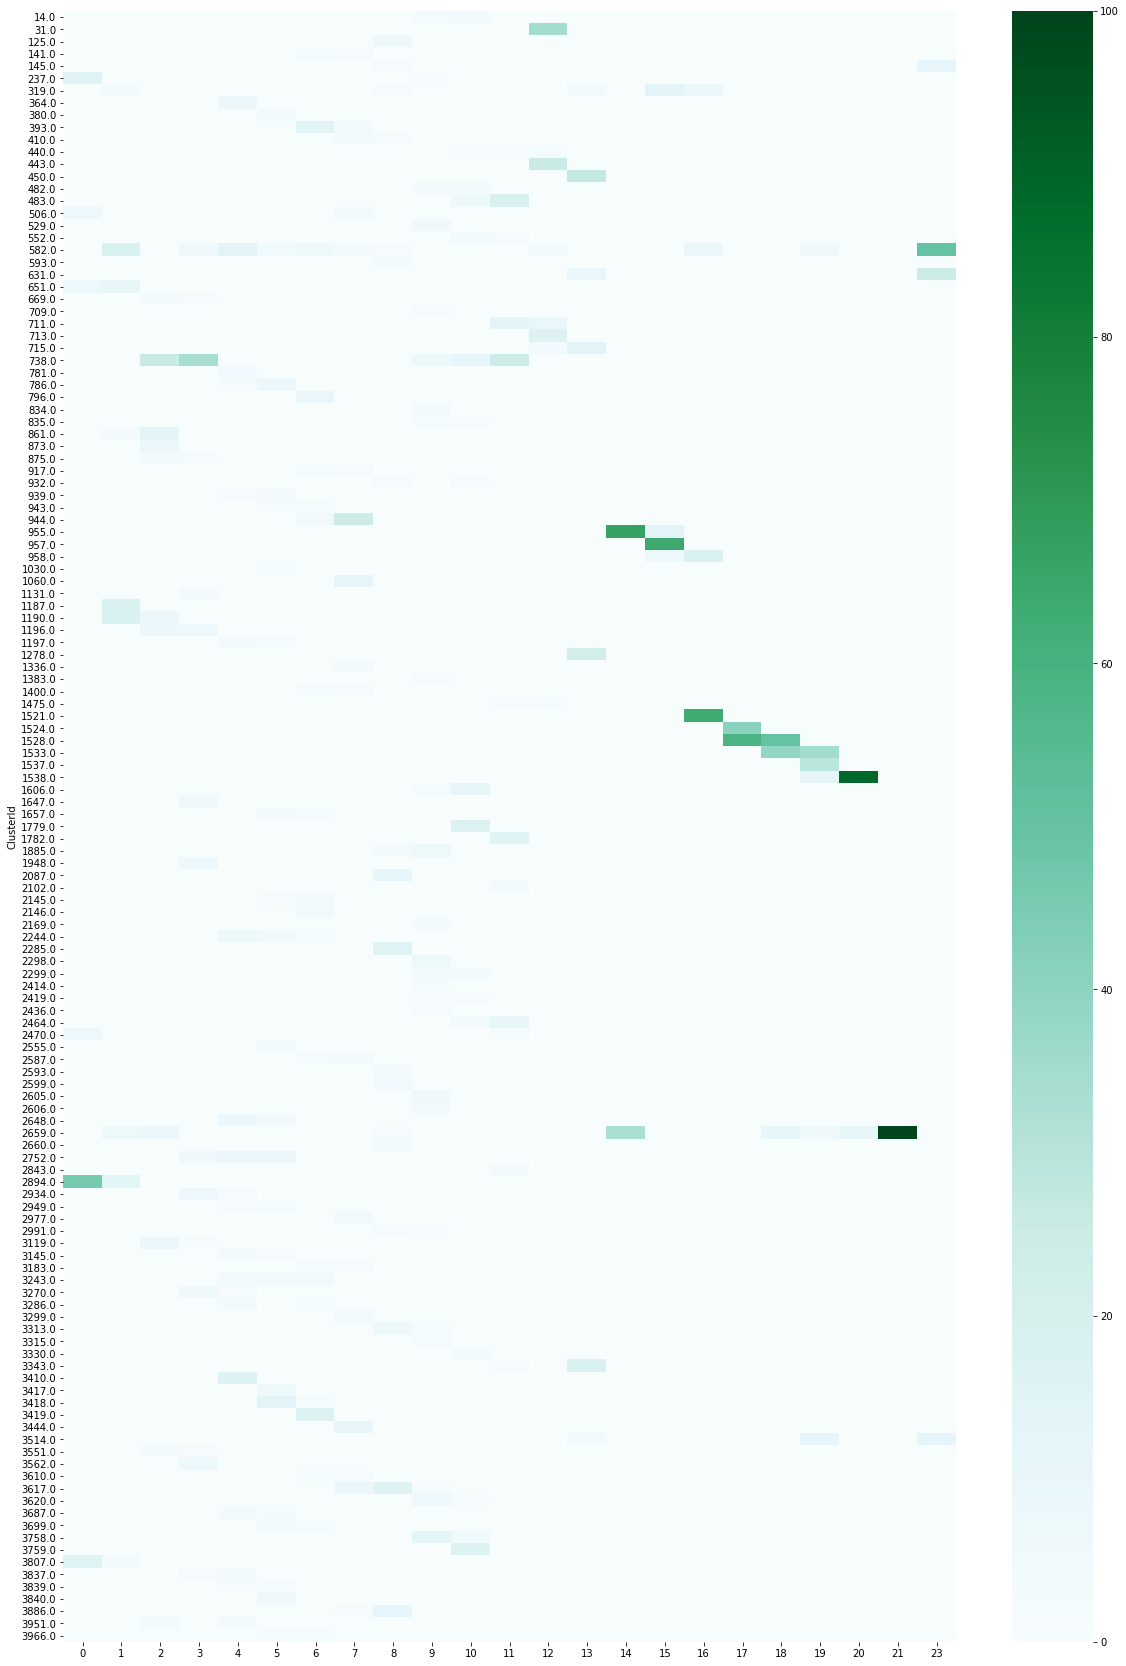

In [35]:
#visualize the staypoint percentage weight per hour
fig, ax = plt.subplots(figsize=(20,30)) 
sns.heatmap(pivot_df_per_weight, cmap='BuGn', ax=ax)

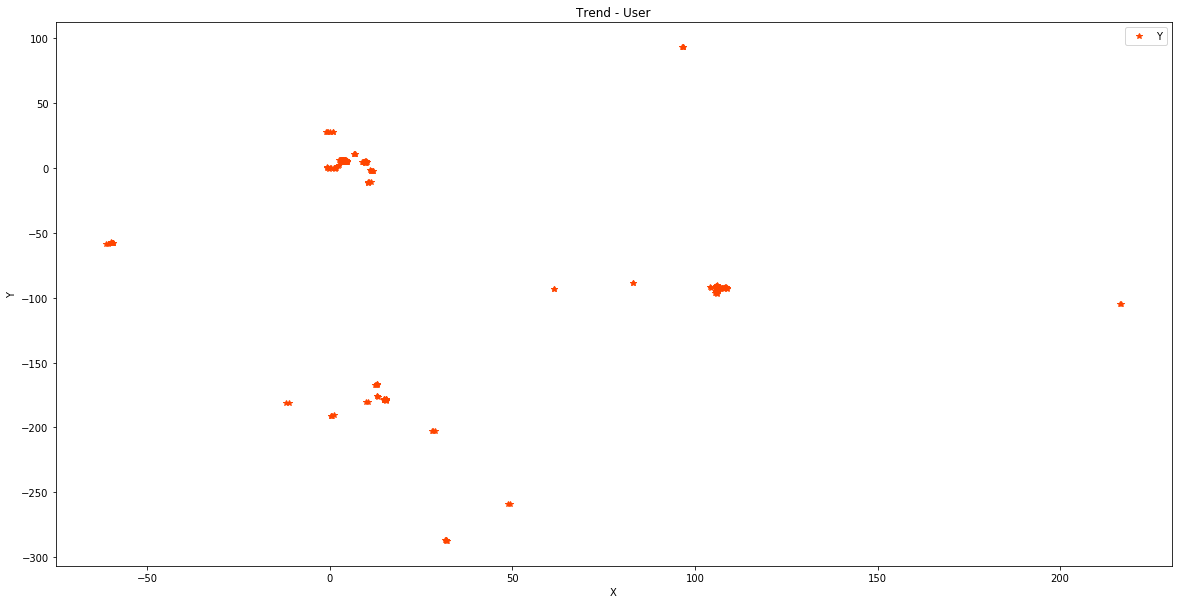

In [11]:
#Plot the significant places
#assign the first lat and log as the base for the plot i.e. origin
origin_lat = math.radians(combined_df["Latitude"][0])
origin_lon = math.radians(combined_df["Longitude"][0])
staypts_df = staypts_df.reset_index(drop=True)

#assign the first lat and log as the base for the plot i.e. origin
origin_lat = math.radians(staypts_df["Latitude"][0])
origin_lon = math.radians(staypts_df["Longitude"][0])

#convert each lat and lon into x and y for the plot w.r.t origin
EARTH_RAD = 6378100
staypts_df['X'] = 0.0
staypts_df['Y'] = 0.0
for i in range(0, len(staypts_df)):
    x = 0
    y = 0
    current_lat = math.radians(staypts_df["Latitude"][i])
    current_lon = math.radians(staypts_df["Longitude"][i])
    x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
    y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
    staypts_df.at[i, 'X'] = x
    staypts_df.at[i, 'Y'] = y

#plot the x and y's
staypts_df.plot(x='X', y= 'Y' , style='*', figsize=(20,10), color='orangered')
plt.title('Trend - User')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()